# Final Project for INFO 6350
### Project Team: Yun Zhou (yz2685)

# Part 0: Background

**Statement of the problem:** The annual financial reports (10K reports) of the publicly traded companies are usually very lengthy and extensive, few people had the time and energy to read such report across all the companies over the years, and make accurate predications on the companies' financial performances based on the hundreds of reports every year of which the average page number can be up to 100 pages or 30k - 60k words. 

**Impact:** The results from my analysis will deliver meaningful recommendations to not only the NLP scholars, but also to the real-world managers,  executives, and investors. By using text mining techniques, we can greatly improve the efficiency of the decision-making process in the business world, saving executives/managers' time reading their competitors' verbose 10K reports. Additionally, the project result will help the individual investors save time analyzing the 10K reports and make better investment decisions in the stock market.   

# Part 1: Research Questions

### Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices? 

### Q2: What are the most important features in the **risk sections** in the 10-k reports that can make predictions or classifications on the companies' stock prices?

### Q3: Given a risk section, can our classifier correctly determine if the record is before-2014 or post-2014?  

# Part 2: Methodologies

**Methodology:** 
* Perform web crawling tasks to collect the financial reports over the years of the companies of interest. 
* Make gold labels based on the companies' financial metrics, such as earnings per share or net profit margin ratio. and label each report as below-average-margin vs. above-average-margin
* Clean the corpus, remove tables, figures, stopwords, etc. 
* Perform sentiment analysis on the corpus to detect the positiveness and/or negativeness of the financial situations of the companies over the years. 
* Build regression models to predict the companies' financial performance and calculate R^2
* Build various classifiers (e.g. random forest, decision tree, SVD, logistic classification, BERT) to classify the companies into below-average and above-average based on the financial metrics. Calculate the F1 and accuracy scores 
* Compare the results from regression models and classifers.
* Make recommendations on how to choose the best stuitable model for such tasks in the future. 

# Part 3: Code

In [1]:
# import libraries
import requests
import urllib
from bs4 import BeautifulSoup
import simplejson as json
from urllib.request import Request, urlopen
from fake_useragent import UserAgent
from selenium import webdriver
import time
import re
import pandas as pd
import json
import datetime
import numpy as np
import unicodedata
from collections import Counter
from nltk import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import pickle
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from   sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, AgglomerativeClustering
import os
import string
import copy
from   collections import defaultdict
from   nltk.corpus import stopwords
from   sklearn.feature_selection import SelectKBest, mutual_info_regression
from wordcloud import WordCloud 
import seaborn as sns
from   sklearn.decomposition import TruncatedSVD


In [2]:
# define the base url needed to create the file url.
base_url = r"https://www.sec.gov"
header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36'
}

# four-digit year pattern
yearPattern = re.compile(r'\d{4}$')

In [3]:
list_cik = pd.read_csv('nasdaq100_ticker_cik_mapping.csv').fillna(value = 0)
len(list_cik)

102

In [4]:
list_cik.head()

,symbol,company,cik,market_cap_05132022,last_sale_05132022,sector
0,AZN,AstraZeneca PLC American Depositary Shares,901832,"195,743,788,762",$63.17,Healthcare
1,ADBE,Adobe Inc. Common Stock,796343,"190,913,625,000",$404.05,Technology Services
2,ODFL,"Old Dominion Freight Line, Inc. Common Stock",878927,"31,335,513,414",$276.44,Industrials
3,LCID,"Lucid Group, Inc. Common Stock",1811210,"30,279,645,603",$18.16,Consumer Cyclical
4,CEG,Constellation Energy Corporation Common Stock,1868275,"18,022,049,404",$55.17,Utilities


## I: Web Scraping

## 1. Scraping the SEC Query Page

In [5]:
# define lists to store the data scraped from the SEC website
ciks = []
risks = []
years = []
urls = []
companies = []
symbols = []
sectors = []

# base URL for the SEC EDGAR browser
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

In [6]:
driver = webdriver.Firefox()

### 1a. Helper functions 

In [7]:
# get the links to the 10k reports 
def get10kPages(url):
    response = requests.get(url = url, headers=header)
    soup10k = BeautifulSoup(response.content, 'html.parser')
    # print(response)
    # print(response.url)
    return response.url

In [8]:
def get10kLinks(url, list_of_10ks):
    response = requests.get(url = url, headers=header)
    soup = BeautifulSoup(response.content, 'html.parser')
    # for a in soup.find_all('a', href=True):
        # url = a['href']
        # print(url)
        
    suffix = "htm";

    tables = soup.find('table')
    rows = tables.find_all('tr')
    if len(rows) > 0:
        row10k = rows[1] # row 1 has link to 10k report
        # print(row10k)
        for a in row10k.find_all('a', href=True):
            url = a['href']
            if url.endswith(suffix):
                list_of_10ks.append("https://www.sec.gov"+ url)
                # print("https://www.sec.gov"+ url)

In [9]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [10]:
# create a function that will scrap the 10k report 
def scrap10k(url, cik, company, symbol, sector):
    driver.get(url)

    time.sleep(2) # give browser some time to load the js 

    html = driver.page_source
    sp = BeautifulSoup(html)
    
    text = ""
    for d in sp.find_all(text=True):
        text += d.get_text()
    
    # cleaning 
    # print(text)
    text = text.replace(u'\xa0', u' ').lower()
                
    # extract risk factor sections only
    # print(url)
    
    # get fiscal year     
    yr = ""
    for span in sp.find_all(text=True):
        stext = span.text
        if (stext.find("January") != -1
         or stext.find("February") != -1
         or stext.find("March") != -1
         or stext.find("April") != -1
         or stext.find("May") != -1
         or stext.find("June") != -1
         or stext.find("July") != -1
         or stext.find("August") != -1
         or stext.find("September") != -1
         or stext.find("October") != -1
         or stext.find("November") != -1
         or stext.find("December") != -1):
            stext = stext.strip()
            yr = stext[-4:]
            # print(yr)
            break
            
    
    # print("=================")    
    # print(text)
    
    # proceed only when a valid year is scraped 
    yr_match = re.match(yearPattern, yr)
    if yr_match != None:
        yr = int(yr) # convert string to int
        if yr > 2006:
            start = find_nth(text, "item 1a.", 2)
            # print("start index", start)
            end = find_nth(text, "item 1b.", 2)
            # print("end index", end)
            substring = text[start:end]
            if len(substring) > 100: # only pull longer risk factors 
                risks.append(substring)
                years.append(yr)
                ciks.append(cik)
                urls.append(url)
                companies.append(company)
                symbols.append(symbol)
                sectors.append(sector)
    #     else:
    #         print("year before 2007: ", yr)
    # else:
    #     print("fiscal year not detected")

In [11]:
def getDataByCIK(cik, company, symbol, sector):
    ########################################
    ### Step 1. Scraping the SEC Query Page
    ########################################
    # define our parameters dictionary
    param_dict = {'action':'getcompany',
                  'CIK': cik,
                  'type':'10-k',
                  'dateb':'20230101',
                  'owner':'exclude',
                  'start':'',
                  'output':'',
                  'count':'100'}

    # request the url, and then parse the response.
    response = requests.get(url = endpoint, params = param_dict, headers=header)
    # response = requests.get(url = endpoint, params = param_dict)
    soup = BeautifulSoup(response.content, 'html.parser')

    # print('Request Successful')
    # print(response.url)
    
    doc_table = soup.find_all(class_ = "blueRow")
    
    data = soup.find_all(class_='blueRow')

    list_10k = []

    for i, row in enumerate(data): 
        for a in data[i].find_all('a', href=True):
            url = a['href']
            if (url.startswith('/Archives/edgar/')):
                list_10k.append("https://www.sec.gov"+ url)
                # print("https://www.sec.gov"+ url)
                
    ########################################
    ### Step 2. Scraping Company Page 
    ########################################
    
    list_of_links = []
    for link in list_10k:
        list_of_links.append(get10kPages(link))
        
    # get the url for 10k report 
    list_of_10ks = []
    for url in list_of_links:
        get10kLinks(url, list_of_10ks)
        

    ########################################
    ### Step 3. Scraping 10k Reports 
    ########################################
    for report in list_of_10ks:
        scrap10k(report, cik, company, symbol, sector)

In [12]:
# test
# scrap10k('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/amzn-20181231x10k.htm', "1018724", "amzn")

In [13]:
# test
# getDataByCIK("1067983", "brk-b")

### 1b. Run scripts for all the companies of interest

In [14]:
%%time
for i, row in list_cik.iterrows():
    getDataByCIK(row.cik, row.company, row.symbol, row.sector)

CPU times: user 17min 55s, sys: 34.4 s, total: 18min 30s
Wall time: 1h 44s


### 1c. Create Data Frame

In [15]:
# create a data frame
data_tuples = list(zip(ciks, symbols, companies, years, risks, sectors, urls))
# data_tuples

df = pd.DataFrame(data_tuples, columns=['cik', 'symbol', 'company', 'fiscal_year', 'risk', 'sector', 'url'])

In [16]:
df.head()

,cik,symbol,company,fiscal_year,risk,sector,url
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Technology Services,https://www.sec.gov/Archives/edgar/data/796343...


In [17]:
len(df)

325

## II. Scrap stock prices from Yahoo Finance 

In [18]:
dict_fi = {}

In [19]:
def getStockPricesByTicker(ticker, fiscal_year, period1, period2):
    url_history = f'https://finance.yahoo.com/quote/{ticker}/history?period1={period1}&period2={period2}&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=false'
    
    respf = requests.get(url_history, headers=header)
    # print(respf)
    
    soupf = BeautifulSoup(respf.text, 'html.parser')
    
    patternf = re.compile(r'\s--\sData\s--\s')
    script_data = soupf.find('script', text=patternf).contents[0]
    
    start = script_data.find("context")-2
    json_data = json.loads(script_data[start:-12])
    
    # get historical stock prices 
    try:
        HistoricalPriceStore = json_data['context']['dispatcher']['stores']['HistoricalPriceStore']
        # print(HistoricalPriceStore)
        # clean the stock price data 
        close = -99999 #default
        for row in HistoricalPriceStore['prices']:
            date = row['date']
            dt_formatted = datetime.datetime.fromtimestamp(date).date() # using the local timezone

            # get the stock price in December of a given year 
            if dt_formatted.month == 12 and dt_formatted.year == fiscal_year and 'close' in row:
                # debug
                # print(ticker, "=========", fiscal_year, "=====", row['date'])
                # print(HistoricalPriceStore)
                close = row['close']
                break # once find a December record then stop looking

        if dict_fi.get(ticker) == None:
            dict_fi[ticker] = {}

        dict_fi[ticker][fiscal_year] = close
    except:
        return None

### 2b. Run scripts for all the records collected from #1

In [20]:
%%time
for i, row in df.iterrows():
    ticker = row.symbol
    fiscal_year = row.fiscal_year
    # period1 = '1167609600' # 2007-01-01
    # period2 = '1672444800' # 2022-12-30
    getStockPricesByTicker(ticker, fiscal_year, '1167609600', '1672444800')

CPU times: user 47.9 s, sys: 2.3 s, total: 50.2 s
Wall time: 11min 29s


### 2c. Create data frames for stock prices

In [21]:
len(dict_fi)

72

In [22]:
df_fi = pd.DataFrame.from_records(
    [
        (level1, level2, leaf)
        for level1, level2_dict in dict_fi.items()
        for level2, leaf in level2_dict.items()
    ],
    columns=['symbol', 'fiscal_year', 'price']
)

In [23]:
df_fi.head()

,symbol,fiscal_year,price
0,ADBE,2018,226.240005
1,ADBE,2016,102.949997
2,ADBE,2014,72.699997
3,ADBE,2012,37.680000
4,ADBE,2010,30.780001


### 2d. Merge two data frames

In [24]:
merged_df = pd.merge(df, df_fi, how='left', on=['fiscal_year','symbol'])

In [25]:
merged_df

,cik,symbol,company,fiscal_year,risk,sector,url,price
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,226.240005
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,102.949997
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,72.699997
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,37.680000
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,30.780001
...,...,...,...,...,...,...,...,...
320,900075,CPRT,"Copart, Inc. (DE) Common Stock",2016,item 1a. risk factorsinvesting in our commo...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,27.705000
321,900075,CPRT,"Copart, Inc. (DE) Common Stock",2014,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,18.245001
322,900075,CPRT,"Copart, Inc. (DE) Common Stock",2013,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,18.325001
323,900075,CPRT,"Copart, Inc. (DE) Common Stock",2010,item 1a. risk factors \n investing ...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,9.337500


## III: Exploratory Analysis & Data Cleaning

### 0. Helper functions

In [26]:
def word_count(text):
    counter = Counter()
    tokens_nltk = word_tokenize(text)

    for token in tokens_nltk:
        counter[token] += 1
    return sum(counter.values())

### 1. Exclude invalid stock prices 

In [27]:
merged_df = merged_df[merged_df['price'] >= 0]

### 2. Clean the text

In [28]:
text_list = []
text_len = []
for text in merged_df['risk']:
    text = unicodedata.normalize('NFKD', text.replace("\'", "'").replace("\ in\ form", " inform").replace("\n", " ").lower().strip())
    text_list.append(text)
    cnt = word_count(text)
    text_len.append(cnt)

### 3. Add more metadata

In [29]:
# add the cleaned text as a column to the df
merged_df['text'] = text_list

/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_5840/237560845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['text'] = text_list


In [30]:
merged_df['word_count'] = text_len

/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_5840/945730304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['word_count'] = text_len


In [31]:
merged_df.describe()

,cik,fiscal_year,price,word_count
count,3.240000e+02,324.000000,324.000000,324.000000
mean,8.967057e+05,2013.320988,93.261426,21207.962963
std,3.842232e+05,3.542147,192.085350,18653.122804
min,2.488000e+03,2007.000000,1.630000,1423.000000
25%,7.738400e+05,2010.000000,25.190000,8537.750000
50%,8.981730e+05,2014.000000,47.769999,13693.500000
75%,1.093557e+06,2016.000000,84.357498,28485.000000
max,1.811210e+06,2020.000000,1722.420044,114960.000000


In [32]:
merged_df.head()

,cik,symbol,company,fiscal_year,risk,sector,url,price,text,word_count
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,226.240005,"item 1a. risk factorsas previously discussed,...",10522
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,102.949997,"item 1a. risk factorsas previously discussed,...",10538
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,72.699997,"item 1a. risk factorsas previously discussed,...",10297
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,37.680000,"item 1a. risk factorsas previously discussed,...",9580
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Technology Services,https://www.sec.gov/Archives/edgar/data/796343...,30.780001,item 1a. risk factors as previously discuss...,8793


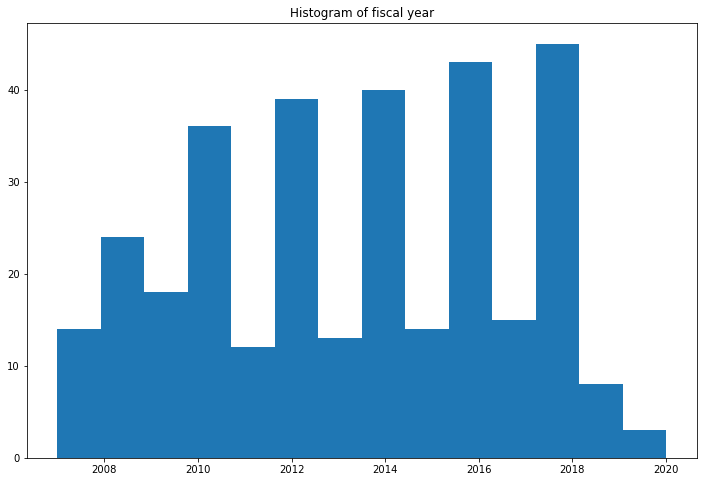

In [33]:
plt.subplots(figsize=(12,8))
plt.hist(merged_df.fiscal_year, bins=merged_df.fiscal_year.nunique())
plt.title("Histogram of fiscal year")
plt.show()

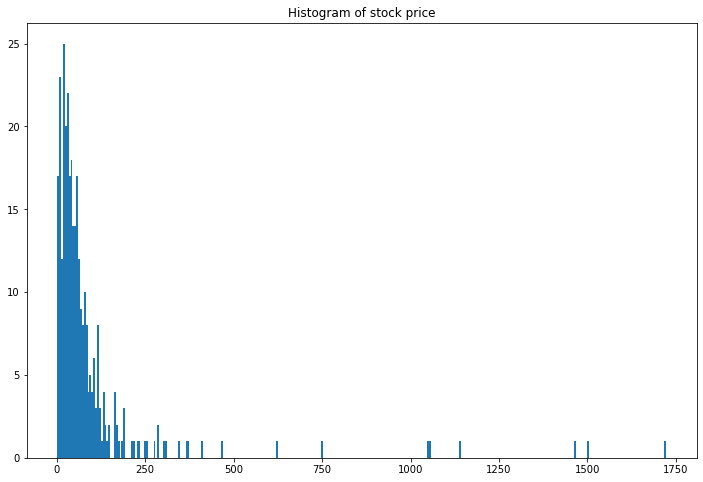

In [34]:
plt.subplots(figsize=(12,8))
plt.hist(merged_df.price, bins=merged_df.price.nunique())
plt.title("Histogram of stock price")
plt.show()

#### It seemed most of the stock prices fall into <= USD 250 bucket. 

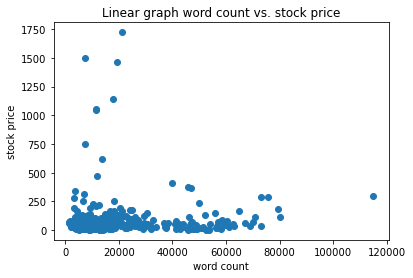

In [35]:
# depicting the visualization
plt.scatter(merged_df.word_count, merged_df.price) 
plt.xlabel('word count') 
plt.ylabel('stock price') 
plt.title("Linear graph word count vs. stock price")
plt.show() 

#### From the graph above, we couldn't find any obvious correlation between word count and stock prices. 

#### I pulled the companies with stock prices above USD 750 for sanity check. It seemed they were accurate. 

In [36]:
merged_df[merged_df.price > 750]

,cik,symbol,company,fiscal_year,risk,sector,url,price,text,word_count
23,1652044,GOOG,Alphabet Inc. Class C Capital Stock,2017,item 1a.risk factorsour operations and financi...,Technology Services,https://www.sec.gov/Archives/edgar/data/165204...,1046.400024,item 1a.risk factorsour operations and financi...,11405
24,1652044,GOOGL,Alphabet Inc. Class A Common Stock,2017,item 1a.risk factorsour operations and financi...,Technology Services,https://www.sec.gov/Archives/edgar/data/165204...,1053.400024,item 1a.risk factorsour operations and financi...,11405
109,1018724,AMZN,"Amazon.com, Inc. Common Stock",2018,item 1a.risk factorsplease carefully consider ...,Retail Trade,https://www.sec.gov/Archives/edgar/data/101872...,1501.969971,item 1a.risk factorsplease carefully consider ...,7367
269,1075531,BKNG,Booking Holdings Inc. Common Stock,2018,item 1a. risk factors the following risk fact...,Consumer Services,https://www.sec.gov/Archives/edgar/data/107553...,1722.420044,item 1a. risk factors the following risk fact...,21340
270,1075531,BKNG,Booking Holdings Inc. Common Stock,2016,item 1a. risk factors the following risk fact...,Consumer Services,https://www.sec.gov/Archives/edgar/data/107553...,1466.060059,item 1a. risk factors the following risk fact...,19489
271,1075531,BKNG,Booking Holdings Inc. Common Stock,2014,item 1a. risk factors the following risk fac...,Consumer Services,https://www.sec.gov/Archives/edgar/data/107553...,1140.209961,item 1a. risk factors the following risk fac...,17825


#### Next, I removed the duplicates in the data frame based on cik and fiscal_year, and removed outliers with stock prices greater than USD 250. 

In [37]:
data = merged_df.drop_duplicates(subset=['cik', 'fiscal_year'])

In [38]:
data = data[data.price <= 250]

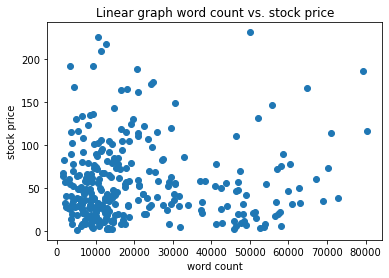

In [39]:
# depicting the visualization after dropping duplicates and outliners 
plt.scatter(data.word_count, data.price) 
plt.xlabel('word count') 
plt.ylabel('stock price') 
plt.title("Linear graph word count vs. stock price")
plt.show() 

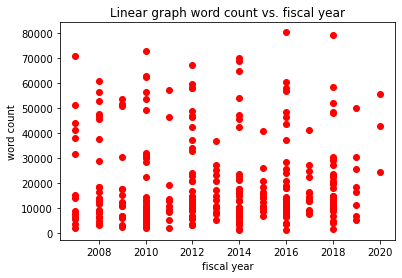

In [40]:
# depicting the visualization
plt.scatter(data.fiscal_year, data.word_count, color="red") 
plt.xlabel('fiscal year') 
plt.ylabel('word count') 
plt.title("Linear graph word count vs. fiscal year")
plt.show() 

#### From the graph above, we couldn't find obvious trend of either decreasing or increasing word count as time goes by. 

### 4. Generate a word cloud based on all the risk text

In [41]:
#convert list to string and generate
all_risks=(" ").join(data.risk)

In [42]:
print(word_count(all_risks))

6314098


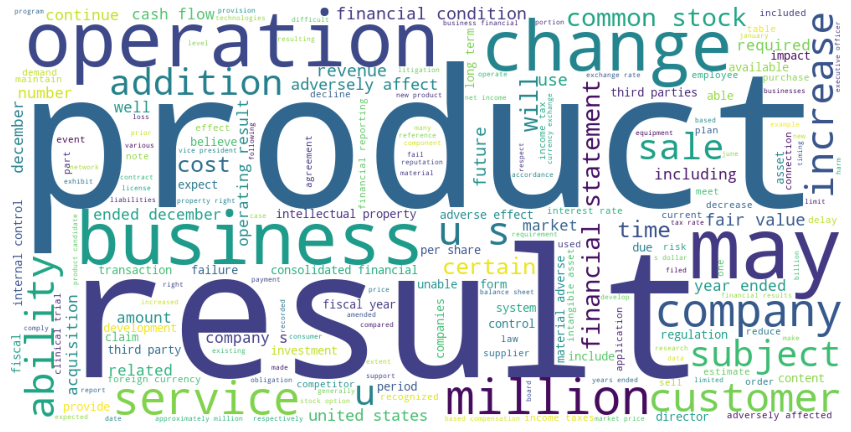

In [43]:
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(all_risks)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("wordcloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

### 5. Save the cleaned data frame

In [44]:
data.to_csv("data.csv", encoding='utf-8', sep=',', header='true')

In [45]:
df = pd.read_csv('data.csv').fillna(value = 0)

In [46]:
cik_ticker = pd.read_csv('nasdaq100_ticker_cik_mapping.csv').fillna(value = 0)

In [47]:
cik_ticker

,symbol,company,cik,market_cap_05132022,last_sale_05132022,sector
0,AZN,AstraZeneca PLC American Depositary Shares,901832,"195,743,788,762",$63.17,Healthcare
1,ADBE,Adobe Inc. Common Stock,796343,"190,913,625,000",$404.05,Technology Services
2,ODFL,"Old Dominion Freight Line, Inc. Common Stock",878927,"31,335,513,414",$276.44,Industrials
3,LCID,"Lucid Group, Inc. Common Stock",1811210,"30,279,645,603",$18.16,Consumer Cyclical
4,CEG,Constellation Energy Corporation Common Stock,1868275,"18,022,049,404",$55.17,Utilities
...,...,...,...,...,...,...
97,TSLA,"Tesla, Inc. Common Stock",1318605,"805,145,473,313",$777.16,Consumer Durables
98,ATVI,"Activision Blizzard, Inc. Common Stock",718877,"61,010,211,260",$78.03,Consumer Durables
99,EA,Electronic Arts Inc. Common Stock,712515,"34,860,312,341",$123.96,Consumer Durables
100,TMUS,"T-Mobile US, Inc. Common Stock",1283699,"158,428,051,195",$126.38,Communications


## IV: Text Analysis

### 0-0. Create gold labels

* Create a vector **y_binary** of gold labels for stock prices. 0 stands for below-average stock prices and 1 represents above-average stock prices. 

In [48]:
y_binary = list(map(lambda x : 0 if x < np.mean(data.price) else 1, data['price']))

In [49]:
len(y_binary)

304

In [50]:
sum(y_binary) / len(y_binary)

0.39473684210526316

### Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices? 

### 1-1. Sentiment Analysis

In [51]:
# Making stopwords list
stoplist = stopwords.words('english')
for el in [i for i in string.punctuation]:
    stoplist.append(el)

In [52]:
emolex_file = os.path.join('emolex.txt')

In [53]:
# read_emolex function from INFO 3350 problem set code

emolex_file = os.path.join('emolex.txt')

def read_emolex(filepath=None):
    '''
    Takes a file path to the emolex lexicon file.
    Returns a dictionary of emolex sentiment values.
    '''
    if filepath==None: # Try to find the emolex file
        filepath = os.path.join('emolex.txt')
        if os.path.isfile(filepath):
            pass
        elif os.path.isfile('emolex.txt'):
            filepath = 'emolex.txt'
        else:
            raise FileNotFoundError('No EmoLex file found')
    emolex = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
    with open(filepath, 'r') as f:
    # emolex file format is: word emotion value
        for line in f:
            word, emotion, value = line.strip().split()
            emolex[word][emotion] = int(value)
    return emolex

# Get EmoLex data. Make sure you set the right file path above.
emolex = read_emolex(emolex_file)

In [54]:
# Get EmoLex df. Make sure you set the right file path above.
emolex = read_emolex(emolex_file)

In [55]:
def getSentScore(sentence_dicts, df, index):
    
    bookdict = dict({'anger': 0 , 'anticipation': 0,'disgust': 0,'fear': 0,'joy': 0,'negative': 0,'positive': 0,'sadness': 0,'surprise': 0, 'trust': 0})
    
    for sentence_dict in sentence_dicts:
        for emotion in sentence_dict:
            bookdict[emotion] += sentence_dict[emotion]
    
    for emotion in bookdict.keys():
        bookdict[emotion] /= len(sentence_dicts)
        df.at[index, emotion] = bookdict[emotion]
    
    return None  

In [56]:
def tokenize_text(text, stops=[]):
    sentences = []
    for sent in sent_tokenize(text.lower()):
        sentences.append([word for word in word_tokenize(sent) if word not in stops])
        
    return sentences

In [57]:
# sentence_sentiment_score from INFO 3350 problem set code
def sentence_sentiment_score(toks, lexicon = emolex):
    total = 0
    emo_dict = defaultdict(lambda: 0)
    
    emotions = ['anger', 'anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']
    
    
    for word in toks:
        total += 1
        for emotion in emotions:
            try:
                emo_dict[emotion] += lexicon[word][emotion]
            except:
                continue
    
    for emotion in emotions:
        if total > 0:
            emo_dict[emotion] /= total
        
    return emo_dict

In [58]:
#### Adding sentiment score columns
size = len(df)

df['anger'] = np.zeros(size)
df['anticipation'] = np.zeros(size)
df['disgust'] = np.zeros(size)
df['fear'] = np.zeros(size)
df['joy'] = np.zeros(size)
df['negative'] = np.zeros(size)
df['positive'] = np.zeros(size)
df['sadness'] = np.zeros(size)
df['surprise'] = np.zeros(size)
df['trust'] = np.zeros(size)

In [59]:
len(df)

304

In [60]:
%%time

for index, text in enumerate(df['risk']):
    sentence_dicts = []
    for sentence in tokenize_text(text, stops=stoplist):
        sentence_dicts.append(sentence_sentiment_score(sentence))
    getSentScore(sentence_dicts, df, index)

CPU times: user 1min 6s, sys: 722 ms, total: 1min 7s
Wall time: 1min 8s


In [61]:
df.tail()

,Unnamed: 0,cik,symbol,company,fiscal_year,risk,sector,url,price,text,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
299,320,900075,CPRT,"Copart, Inc. (DE) Common Stock",2016,item 1a. risk factorsinvesting in our commo...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,27.705000,item 1a. risk factorsinvesting in our commo...,...,0.019701,0.038329,0.016762,0.030321,0.009661,0.066185,0.094219,0.023611,0.008625,0.052095
300,321,900075,CPRT,"Copart, Inc. (DE) Common Stock",2014,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,18.245001,item 1a. risk factors investing in our co...,...,0.023981,0.037899,0.019341,0.033534,0.010873,0.066368,0.096863,0.026728,0.007782,0.053089
301,322,900075,CPRT,"Copart, Inc. (DE) Common Stock",2013,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,18.325001,item 1a. risk factors investing in our co...,...,0.024179,0.039362,0.020800,0.036514,0.010880,0.067244,0.098653,0.028181,0.007672,0.053146
302,323,900075,CPRT,"Copart, Inc. (DE) Common Stock",2010,item 1a. risk factors \n investing ...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,9.337500,item 1a. risk factors investing i...,...,0.023554,0.040803,0.019069,0.033254,0.010905,0.065662,0.104372,0.025967,0.006681,0.050782
303,324,900075,CPRT,"Copart, Inc. (DE) Common Stock",2009,item 1a. risk factors \n investi...,Commercial Services,https://www.sec.gov/Archives/edgar/data/900075...,9.155000,item 1a. risk factors investin...,...,0.024608,0.038114,0.019443,0.033097,0.011708,0.066980,0.103876,0.026330,0.005692,0.049739


In [62]:
df.describe()

,Unnamed: 0,cik,fiscal_year,price,word_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
count,304.000000,3.040000e+02,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,160.911184,8.834649e+05,2013.154605,55.872967,20770.375000,0.017637,0.041907,0.009962,0.027525,0.018901,0.059696,0.105277,0.023928,0.009313,0.059365
std,94.628030,3.874983e+05,3.549617,45.485301,17656.526626,0.004749,0.006466,0.003954,0.006934,0.004922,0.011735,0.009175,0.005281,0.003183,0.008030
min,0.000000,2.488000e+03,2007.000000,1.630000,1423.000000,0.007411,0.027373,0.001337,0.011841,0.005467,0.034340,0.081583,0.012612,0.003284,0.039743
25%,77.750000,7.693970e+05,2010.000000,22.351250,8559.500000,0.014453,0.037874,0.007385,0.021839,0.016099,0.050279,0.099411,0.020588,0.007238,0.054046
50%,162.500000,8.911030e+05,2013.000000,43.465000,13549.000000,0.017320,0.042030,0.009856,0.028327,0.018006,0.060357,0.105674,0.023531,0.008982,0.058147
75%,240.250000,1.094455e+06,2016.000000,74.807501,27734.750000,0.020033,0.044576,0.012538,0.032216,0.020773,0.067393,0.111322,0.027425,0.010611,0.063793
max,324.000000,1.811210e+06,2020.000000,231.669998,80342.000000,0.041867,0.069143,0.027367,0.050213,0.037843,0.093268,0.130600,0.042139,0.021311,0.086329


In [63]:
grouped_sent = df.groupby(y_binary).mean()\
[['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']]

print("Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in \
the corpus. \n\
'True' indicates detective novels.")

grouped_sent

Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in the corpus. 
'True' indicates detective novels.


,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0.017662,0.041922,0.010006,0.027683,0.018833,0.059660,0.104365,0.02416,0.009218,0.058108
1,0.017599,0.041885,0.009894,0.027282,0.019003,0.059752,0.106675,0.02357,0.009458,0.061293


In [64]:
sent_dict = grouped_sent.to_dict()

In [65]:
# from INFO 3350 problem set
def visualize_emotion_scores(scores):
    df = pd.DataFrame.from_dict(scores)
    values = df.columns
    df = df.reset_index().melt(id_vars='index', value_vars=values, var_name='emotion').rename(columns={'index':'stockPrice'})
    sns.set_context('poster')
    g = sns.catplot(x='stockPrice', y='value', col='emotion', data=df, kind='bar', col_wrap=4)
    return g

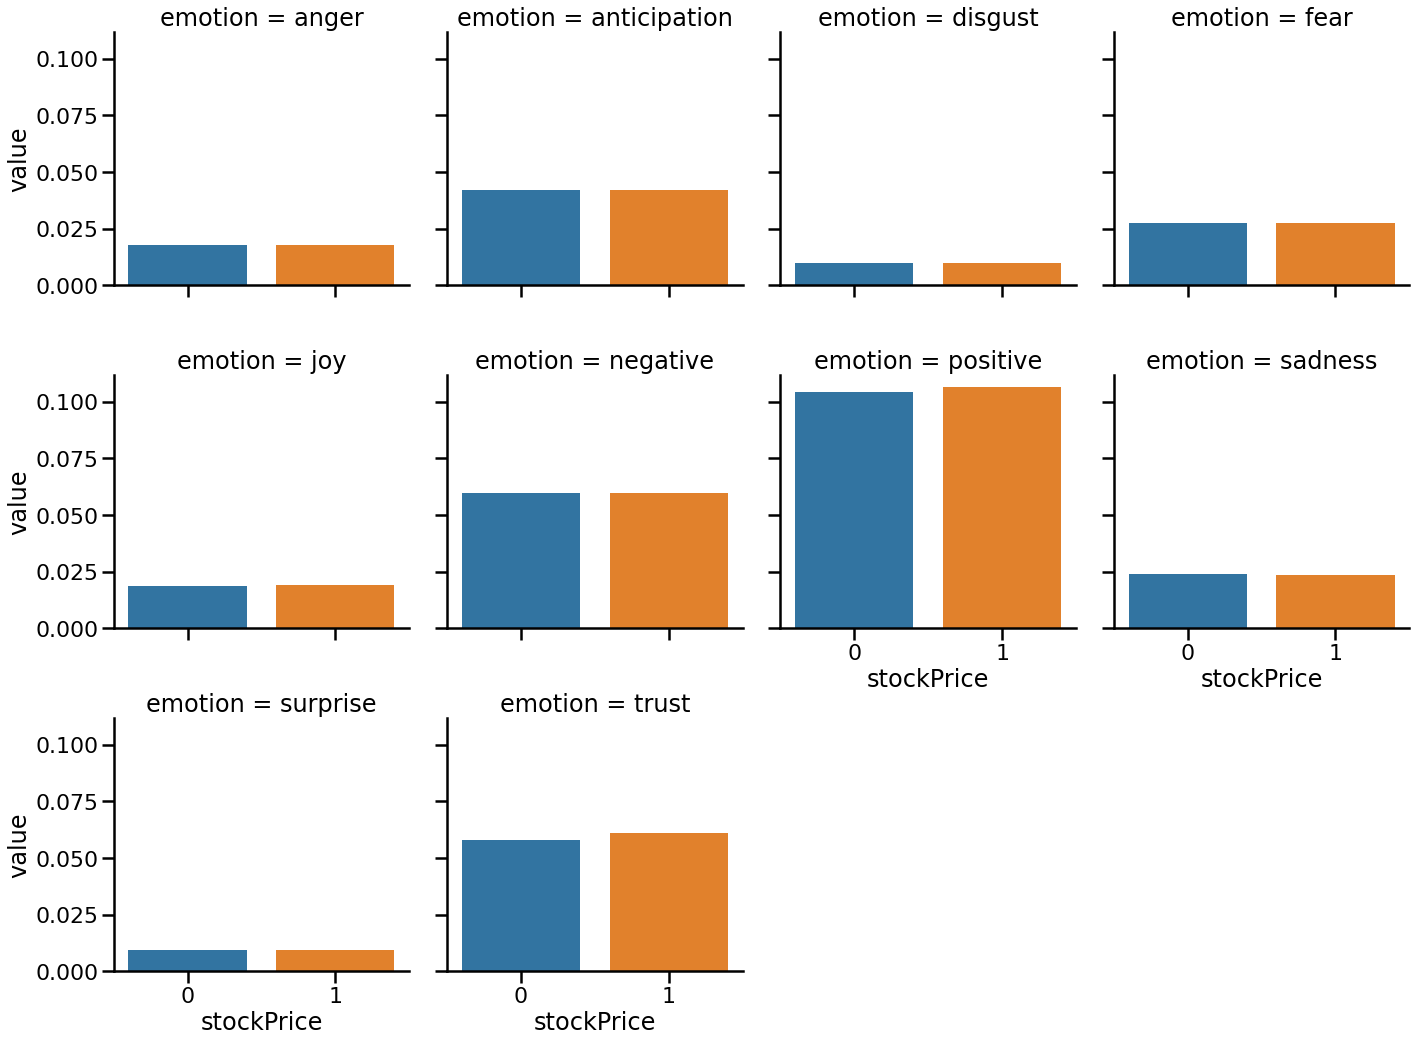

In [66]:
visualize_emotion_scores(sent_dict)

#### (1) Acorss all the emotions, it seemed those publicly traded companies tended to use **positive** tones in their writings of the Risk Factors section no matter what their stock performances were, compared to any other emotions. 

#### (2) The emotion **surprise** is the least mentioned in the Risk Factors section. It seemed those companies used caution when publishing their 10-K annual reports, trying not to deliver any surprising messages to scare them away. 

#### (3) Comparing the emotion scores by stock price, there did not appear to be any significant differences between below-average and above-average stock prices.

### 1-2-0 Create Vectorizer

In [67]:
# Vectorize
vectorizer = TfidfVectorizer(
    encoding = 'utf-8',
    strip_accents = 'unicode',
    lowercase = True,
    min_df = 0.01,
    max_df = 0.9,
    use_idf=True
)

In [68]:
# perform vectorization
X = vectorizer.fit_transform(df.risk.values.astype('U'))
print("Shape of the feature matrix", X.shape)

Shape of the feature matrix (304, 12834)


In [69]:
# standard-scale feature matrix
X = StandardScaler().fit_transform(X.todense())

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


### 1-2. Clustering

In [70]:
############## code from INFO 6350 problem set code ##############
def plot_compare(X, labels, title, reduce=True, alpha=0.2):
    '''
    Takes an array of object data, a set of cluster labels, and a title string
    Reduces dimensions to 2 and plots the clustering.
    Returns nothing.
    '''
    
    if reduce:
        # TruncatedSVD is fast and can handle sparse inputs
        # PCA requires dense inputs; MDS is slow
        coordinates = TruncatedSVD(n_components=2).fit_transform(X)
    else:
        # Optionally handle 2-D inputs
        coordinates = X
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(12,6))

    # Unlabeled data
    plt.subplot(121) # 1x2 plot, position 1
    plt.scatter(
        coordinates[:, 0], 
        coordinates[:, 1], 
        alpha=alpha, # Set transparency so that we can see overlapping points
        linewidths=0 # Get rid of marker outlines
    )
    plt.title("Unclustered data")

    # Labeled data
    plt.subplot(122)
    sns.scatterplot(
        x=coordinates[:, 0], 
        y=coordinates[:, 1],
        hue=labels,
        alpha=alpha,
        palette='viridis',
        linewidth=0
    )
    plt.title(title)
    plt.show()

In [71]:
############## code from INFO 6350 problem set code ##############
def pull_samples(texts, labels, n=3):
    '''
    Takes lists of texts and an array of labels, as well as number of samples to return per label.
    Prints sample texts belonging to each label.
    '''
    texts_array = np.array(texts) # Make the input text list easily addressable by NumPy
    for label in np.unique(labels): # Iterate over labels
        print("Label:", label)
        sample_index = np.where(labels == label)[0] # Limit selection to current label
        print("Number of texts in this cluster:", len(sample_index), '\n')
        chosen = np.random.choice(sample_index, size=n) # Sample n texts with this label
        for choice in chosen:
            print("Sample text:", choice)
            # print(str(texts_array[choice]).split(" 0")[0], '\n') # Print each sampled text
            print(str(texts_array[choice])[1:80]) # Print each sampled text
            print("fiscal year: ", texts.fiscal_year[choice])
            print("company: ", texts.company[choice])
            print("word count: ", texts.word_count[choice])
            print("sector: ", texts.sector[choice])
            print(texts.url[choice], '\n')
        print("###################################")

Label vector shape:  (304,)
Using KMeans clustering with n=2 clusters; we are assuming that the clusters are detective and non-detective novels.


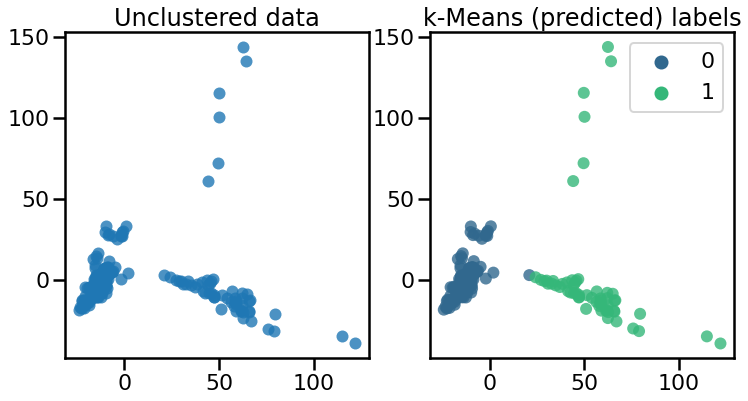

In [72]:
y_kmeans = KMeans(n_clusters=2).fit_predict(X) # this output is the cluster labels

# Print label vector shape
print('Label vector shape: ', y_kmeans.shape)

print("Using KMeans clustering with n=2 clusters; we are assuming that the clusters are detective and non-detective novels.")

# Plot results
plot_compare(X, y_kmeans, 'k-Means (predicted) labels', reduce=True, alpha=0.8)

In [73]:
pull_samples(df, y_kmeans, 5)

Label: 0
Number of texts in this cluster: 246 

Sample text: 33
35 1633917 'PYPL' 'PayPal Holdings, Inc. Common Stock' 2018
 "item 1a. risk fac
fiscal year:  2018
company:  PayPal Holdings, Inc. Common Stock
word count:  27347
sector:  Technology Services
https://www.sec.gov/Archives/edgar/data/1633917/000163391719000043/pypl201810-k.htm 

Sample text: 286
307 718877 'ATVI' 'Activision Blizzard, Inc. Common Stock' 2016
 'item 1a.    r
fiscal year:  2016
company:  Activision Blizzard, Inc. Common Stock
word count:  13198
sector:  Consumer Durables
https://www.sec.gov/Archives/edgar/data/718877/000104746917001072/a2230993z10-k.htm 

Sample text: 196
209 2488 'AMD' 'Advanced Micro Devices, Inc. Common Stock' 2018
 'item 1a. risk
fiscal year:  2018
company:  Advanced Micro Devices, Inc. Common Stock
word count:  14975
sector:  Electronic Technology
https://www.sec.gov/Archives/edgar/data/2488/000000248819000011/amd-12292018x10k.htm 

Sample text: 298
319 900075 'CPRT' 'Copart, Inc. (DE) Co

In [74]:
df.url[15]

'https://www.sec.gov/Archives/edgar/data/277948/000027794813000008/csx-12282012x10k.htm'

### Q2: What are the most important features in the **risk sections** in the 10-k reports that can make predictions or classifications on the companies' stock prices?

### 2-1. Build a token-based classifier

In [75]:
%%time
# Select best features
selector = SelectKBest(score_func=mutual_info_regression, k=50)

# Print the shape of your new feature matrix
X_top = selector.fit_transform(X, y_binary)
print("Shape of the combined matrix with 300 selected features: ", X_top.shape)

Shape of the combined matrix with 300 selected features:  (304, 50)
CPU times: user 21.9 s, sys: 167 ms, total: 22.1 s
Wall time: 22.1 s


In [76]:
# Calculate a 10-fold cross-validated accuracy score using a logistic regression classifier on your selected feature data.
# Cross-validate the logistic regression classifier on full input data
print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(LogisticRegression(), X_top, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.5754838709677419


In [77]:
feature_names = vectorizer.get_feature_names()
feature_names_ = [feature_names[i] for i in selector.get_support(indices=True)]

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [78]:
feature_names_

['191',
 '20174',
 '31table',
 '534',
 'akita',
 'amea',
 'arab',
 'bargaining',
 'biologics',
 'cancelled',
 'carryforwards',
 'characters',
 'coca',
 'constrain',
 'consult',
 'corrupt',
 'csf',
 'dispensing',
 'disproportionate',
 'dry',
 'everyone',
 'extortion',
 'fabless',
 'footnotes',
 'guide',
 'illegally',
 'importers',
 'interfaces',
 'king',
 'label',
 'landscape',
 'mercexchange',
 'methane',
 'negotiations',
 'outlooks',
 'participated',
 'piece',
 'predictive',
 'prevented',
 'profile',
 'renewables',
 'reverse',
 'rigorous',
 'schemes',
 'summarizes',
 'threatened',
 'transferable',
 'translation',
 'unenforceable',
 'wyman']

### 2-2. Build a word-embedding-based classifier

In [79]:
def get_doc_embedding(doc, nlp):    
    # remove_noninformative_tokens
    tokens = nlp(doc)
    culled = []
    culled = [token for token in tokens if not (token.is_stop or token.is_punct or token.is_space) and token.has_vector]
    '''
    Takes two lists of spacy token objects.
    Returns cosine similarity between their embedding representations.
    '''
    mean_vector_culled = np.mean([token.vector for token in culled], axis=0)
       
    return mean_vector_culled

In [80]:
nlp = spacy.load("en_core_web_lg") # Note '_lg' = large model

In [81]:
%%time
X_embedding = []
X_embedding = np.zeros((len(df.risk), nlp.vocab.vectors_length))

for i, content in enumerate(df.risk):
    X_embedding[i] = get_doc_embedding(content, nlp)  

CPU times: user 19min 1s, sys: 2min 20s, total: 21min 21s
Wall time: 21min 34s


In [82]:
print("Shape of embedding matrix: ", X_embedding.shape)

Shape of embedding matrix:  (304, 300)


In [83]:
# standard-scale feature matrix
X_embedding = StandardScaler().fit_transform(X_embedding)

In [84]:
# Calculate a 10-fold cross-validated accuracy score using a logistic regression classifier on your selected feature df.
# Cross-validate the logistic regression classifier on full input data

print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(LogisticRegression(max_iter=500), X_embedding, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.5623655913978494


### 2-3. Evaluate regression performance

In [85]:
print("Token-based Mean 10-fold cross-validated R^2:", 
      np.mean(cross_val_score(LinearRegression(), X_embedding, y_binary, scoring='r2', cv=10)))

Token-based Mean 10-fold cross-validated R^2: -95.504491032431


In [86]:
print("Embedding-based Mean 10-fold cross-validated R^2:", 
      np.mean(cross_val_score(LinearRegression(), X_embedding, y_binary, scoring='r2', cv=10)))

Embedding-based Mean 10-fold cross-validated R^2: -95.504491032431


### 2-4. Improve classification performance

#### 2-4-1. Improve token-based classifier

##### Feature Engineering
* Let's increase the number of features from 300 to 800

In [87]:
selector_k = SelectKBest(score_func=mutual_info_regression, k=20)

In [88]:
# Print the shape of your new feature matrix
X_token_k = selector_k.fit_transform(X, y_binary)
print("Shape of the matrix with 20 selected features: ", X_token_k.shape)

Shape of the matrix with 20 selected features:  (304, 20)


In [89]:
print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(LogisticRegression(), X_token_k, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.5534408602150537


In [90]:
%%time
print("Random Forest === Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(RandomForestClassifier(max_features="auto"), X_token_k, y_binary, scoring='accuracy', cv=10)))

Random Forest === Mean cross-validated accuracy scores: 0.6154838709677419
CPU times: user 1.67 s, sys: 22.3 ms, total: 1.69 s
Wall time: 1.14 s


In [91]:
%%time
print("Decision Tree === Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(DecisionTreeClassifier(max_depth=100), X_token_k, y_binary, scoring='accuracy', cv=10)))

Decision Tree === Mean cross-validated accuracy scores: 0.6189247311827957
CPU times: user 15.2 ms, sys: 1.65 ms, total: 16.9 ms
Wall time: 15.8 ms


#### 2-4-2. Improve embedding-token-based classifier

##### Try SVM classifier
* linear SVM 
* non-linear SVM

In [93]:
%%time
print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(SVC(), X_embedding, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.5116129032258063
CPU times: user 80.6 ms, sys: 3.27 ms, total: 83.8 ms
Wall time: 86.6 ms


### 2-5. Conclusion on Q2

# Part 4: Results and Discussion

# Part 5: Reflection

# Part 6: References

* https://stackoverflow.com/questions/48687857/python-json-list-to-pandas-dataframe

* https://www.youtube.com/watch?v=fw4gK-leExw&ab_channel=IzzyAnalytics

# Part 7: Responsibility Statement

I completed this project on my own. 